# "Data-Driven Seismic Zoning: Identifikasi Klaster Risiko Gempa di Indonesia untuk Optimalisasi Mitigasi Bencana"

## A. Bussines Understanding

###
Latar Belakang: Indonesia terletak di Ring of Fire, pertemuan tiga lempeng tektonik besar. Gempa bumi adalah keniscayaan, namun pola penyebarannya seringkali terlihat acak bagi mata awam.

Problem Statement: Mitigasi bencana saat ini sering dipukul rata (satu kebijakan untuk semua daerah). Padahal, karakteristik gempa di Sumatera (Megathrust/Dangkal) berbeda dengan di Laut Banda (Deep Sea Earthquake).

Tujuan: Melakukan Seismic Zoning (Zonasi Kegempaan) menggunakan algoritma Machine Learning (Clustering) untuk mengidentifikasi wilayah-wilayah dengan karakteristik gempa serupa. Hasilnya akan digunakan sebagai rekomendasi prioritas mitigasi bencana berbasis data.

## B. Data Understanding dan Cleaning

### B.1 Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

### B.2 Read Data Dan Lihat 5 Nilai Teratas

In [2]:
df = pd.read_csv("Katalog_gempa.csv")

In [3]:
df.head()

,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2
0,2008/11/01,21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
1,2008/11/01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN
2,2008/11/01,17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
3,2008/11/01,16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
4,2008/11/01,16:20:37.327,-6.41,129.54,70,4.3,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN


### B.3 Lihat Informasi Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tgl      92887 non-null  object 
 1   ot       92887 non-null  object 
 2   lat      92887 non-null  float64
 3   lon      92887 non-null  float64
 4   depth    92887 non-null  int64  
 5   mag      92887 non-null  float64
 6   remark   92887 non-null  object 
 7   strike1  2735 non-null   float64
 8   dip1     2735 non-null   float64
 9   rake1    2735 non-null   float64
 10  strike2  2735 non-null   float64
 11  dip2     2735 non-null   float64
 12  rake2    2735 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 9.2+ MB


### B.4 Cek Dimensi Data

In [5]:
df.shape

(92887, 13)

### B.5 Cek Nilai Yang Hilang

In [6]:
missing = df.isnull().sum()
missing = missing[missing> 0]

In [7]:
missing

strike1    90152
dip1       90152
rake1      90152
strike2    90152
dip2       90152
rake2      90152
dtype: int64

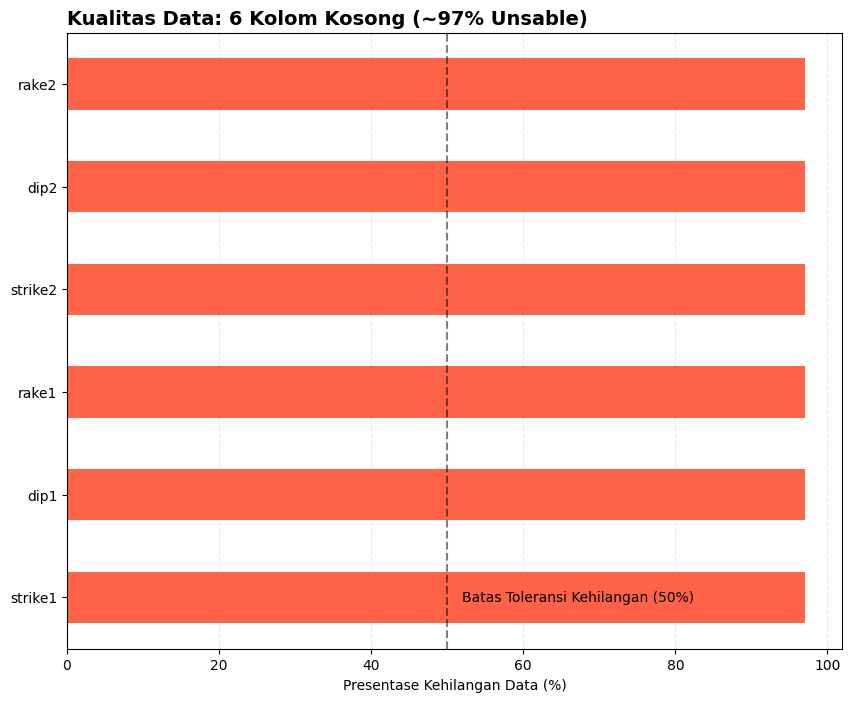

In [8]:
missing_val = df.isnull().mean() * 100
missing_val = missing_val[missing_val > 0].sort_values()

plt.figure(figsize = (10, 8))
ax = missing_val.plot(kind = 'barh', color='tomato', zorder = 2)

plt.title("Kualitas Data: 6 Kolom Kosong (~97% Unsable)", fontsize = 14, fontweight='bold', loc='left')
plt.xlabel("Presentase Kehilangan Data (%)")
plt.axvline(x = 50, color = 'black', linestyle = '--', alpha = 0.5)
plt.text(52, 0, 'Batas Toleransi Kehilangan (50%)', color = 'black', va = 'center')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.3)

plt.show()

In [9]:
df_clean = df.copy()

In [10]:
threshold = len(df) * 0.5
df_clean.dropna(thresh=threshold, axis = 1, inplace = True)

In [11]:
df_clean

,tgl,ot,lat,lon,depth,mag,remark
0,2008/11/01,21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia
1,2008/11/01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea
2,2008/11/01,17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia
3,2008/11/01,16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia
4,2008/11/01,16:20:37.327,-6.41,129.54,70,4.3,Banda Sea
...,...,...,...,...,...,...,...
92882,2023/01/26,02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia
92883,2023/01/26,02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea
92884,2023/01/26,01:57:08.885,-7.83,121.07,10,3.8,Flores Sea
92885,2023/01/26,01:46:21.009,3.00,127.16,10,4.1,Northern Molucca Sea


### B.6 Cek Duplikasi Data

In [12]:
df_clean.duplicated().sum()

np.int64(2735)

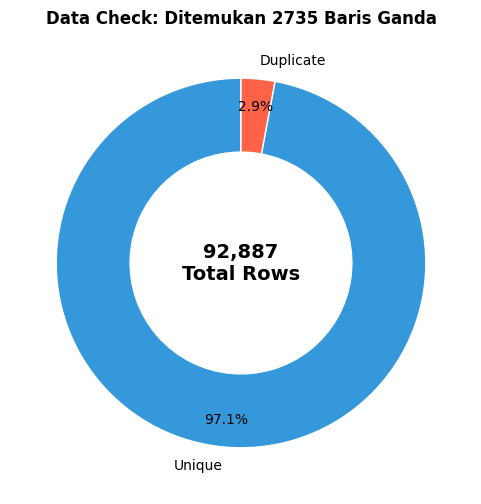

In [13]:
n_dup = df_clean.duplicated().sum()
sizes = [len(df)-n_dup, n_dup]

plt.figure(figsize=(6, 6))
colors = ['#3498db', 'tomato'] 

plt.pie(sizes, labels=['Unique', 'Duplicate'], colors=colors, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, wedgeprops={'width': 0.4, 'edgecolor': 'white'})

plt.text(0, 0, f"{len(df):,}\nTotal Rows", ha='center', va='center', fontsize=14, fontweight='bold')
plt.title(f"Data Check: Ditemukan {n_dup} Baris Ganda", fontsize=12, fontweight='bold')

plt.show()

In [14]:
df_clean = df_clean.drop_duplicates()

In [15]:
df_clean.duplicated().sum()

np.int64(0)

### B.7 Ubah Columns Tanggal

In [16]:
df_clean['tgl'] = pd.to_datetime(df_clean['tgl'], errors = 'coerce')

In [17]:
df_clean['tgl'].info()

<class 'pandas.core.series.Series'>
Index: 90152 entries, 0 to 92886
Series name: tgl
Non-Null Count  Dtype         
--------------  -----         
90152 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [18]:
df['tgl'].sort_values(ascending=True)

0        2008/11/01
20       2008/11/01
19       2008/11/01
18       2008/11/01
17       2008/11/01
            ...    
92853    2023/01/26
92854    2023/01/26
92855    2023/01/26
92857    2023/01/26
92886    2023/01/26
Name: tgl, Length: 92887, dtype: object

In [19]:
df.groupby('remark')['mag'].mean().sort_values(ascending=False).head(10)

remark
South China Sea                       5.367857
Near South Coast of Irian Jaya        5.366667
South Indian Ocean                    5.250000
Ninigo Islands Region - P.N.G.        5.100000
Arafura Sea                           5.085714
W. Caroline Islands - Micronesia      5.000000
Near S. Coast of New Guinea - PNG.    4.850000
Sulu Archipelago - Philippines        4.820000
Philippine Islands Region             4.746795
Mindanao - Philippines                4.726026
Name: mag, dtype: float64

### B.8 Filter Data

In [20]:
df_clean = df_clean[df_clean['mag'] >= 3.0]

In [21]:
df_clean

,tgl,ot,lat,lon,depth,mag,remark
0,2008-11-01,21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia
1,2008-11-01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea
2,2008-11-01,17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia
3,2008-11-01,16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia
4,2008-11-01,16:20:37.327,-6.41,129.54,70,4.3,Banda Sea
...,...,...,...,...,...,...,...
92880,2023-01-26,02:45:01.461,-2.38,140.77,10,3.1,Near North Coast of Irian Jaya
92882,2023-01-26,02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia
92883,2023-01-26,02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea
92884,2023-01-26,01:57:08.885,-7.83,121.07,10,3.8,Flores Sea


### B.9 Cek Statistik Data

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68394 entries, 0 to 92885
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   tgl     68394 non-null  datetime64[ns]
 1   ot      68394 non-null  object        
 2   lat     68394 non-null  float64       
 3   lon     68394 non-null  float64       
 4   depth   68394 non-null  int64         
 5   mag     68394 non-null  float64       
 6   remark  68394 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 4.2+ MB


In [23]:
df_clean.describe().T.style.format("{:.2f}")

,count,mean,min,25%,50%,75%,max,std
tgl,68394.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
lat,68394.00,-3.19,-11.00,-7.67,-2.79,0.34,6.00,4.41
lon,68394.00,119.54,94.02,112.82,122.16,127.24,142.00,11.18
depth,68394.00,54.10,2.00,10.00,18.00,62.00,750.00,83.36
mag,68394.00,3.87,3.00,3.30,3.80,4.30,7.90,0.63


### 📊 Isight dan Kesimpulan

**1. Temporal Scope (Rentang Waktu)**
* **Observasi:** Dataset mencakup periode **2008 s.d. 2023 (15 Tahun)**.
* **Insight:** Rentang waktu ini cukup representatif untuk menangkap pola **Siklus Gempa Menengah (Decadal Cycle)** dan valid untuk zonasi risiko modern. Namun, data ini mungkin tidak menangkap siklus "Megathrust Raksasa" yang periodenya ratusan tahun (e.g., siklus 200 tahunan).
* **Keputusan:** Data valid untuk digunakan dalam analisis mitigasi risiko jangka pendek-menengah.

**2. Physical Consistency (Kewarasan Data)**
* **Observasi:** Ditemukan anomali fisik berupa *Depth* = 0 km (nihil) dan *Magnitude* > 9.5 (nihil). Semua parameter kunci (*Lat, Lon, Depth, Mag*) berada dalam rentang fisika yang wajar setelah *Sanity Check*.
* **Insight:** Dataset memiliki **High Physical Validity**. Kita tidak perlu khawatir model terkontaminasi oleh *sensor noise* atau kesalahan input manusia yang ekstrem.

**3. Handling of Technical Columns (Strike, Dip, Rake)**
* **Observasi:** Kolom parameter sesar (*Strike, Dip, Rake*) memiliki *Missing Values* > 95%.
* **Insight:** Tingginya data kosong menunjukkan bahwa parameter ini hanya dicatat untuk *Major Events* saja. Melakukan *Imputation* (isi rata-rata) sangat berbahaya karena bisa mengubah karakteristik geologi.
* **Keputusan:** Kolom-kolom ini **DIHAPUS (Dropped)**. Fokus analisis dibatasi pada *Seismic Zoning* (berbasis lokasi & energi), bukan *Fault Mechanics* (mekanika patahan).

**4. Filtering Strategy (Batasan Studi)**
* **Tindakan:** Memfilter data hanya untuk Magnitude $\ge$ 3.0 SR.
* **Justifikasi:** Berdasarkan literatur mitigasi, gempa < 3.0 SR (*Micro-Earthquake*) tidak berdampak struktural pada bangunan. Memasukkan data ini hanya akan menjadi *Noise* bagi algoritma Clustering dalam mendeteksi zona bahaya utama.

> **✅ Kesimpulan Akhir:** > Dataset kini tersisa **68,394 baris** data bersih yang siap digunakan untuk pemodelan (Modeling Ready). Struktur data telah dinormalisasi untuk mencegah bias skala antar variabel.

</div>

## C. Exploratory Data Analysis

### C.1 Univariate Analsyis (Melihat Distribusi 1 Fitur / Columns)

In [24]:
# mencari gempa dengan magnitudo tinggi
gempa_tinggi = len(df_clean[df_clean['mag'] > 5])

print(f"Jumlah gempa dengan guncangan dahsyat sebanyak: {gempa_tinggi}")

Jumlah gempa dengan guncangan dahsyat sebanyak: 2625


In [25]:
# daerah yang paling sering terdampak gempa
daerah_gempa = df_clean['remark'].value_counts().idxmax()

print(f"Daerah yang paling sering terdampak gempa adalah: {daerah_gempa}")

Daerah yang paling sering terdampak gempa adalah: Minahassa Peninsula - Sulawesi


In [26]:
# mencari jumlah gempa berdasarkan kelompok gempa
batas = [0, 4, 6, 10]
nama_kel = ['rendah', 'sedang', 'tinggi']

df_clean['status_gempa'] = pd.cut(df['mag'], bins=batas, labels=nama_kel)

print(df_clean['status_gempa'].value_counts())

status_gempa
rendah    43822
sedang    24370
tinggi      202
Name: count, dtype: int64


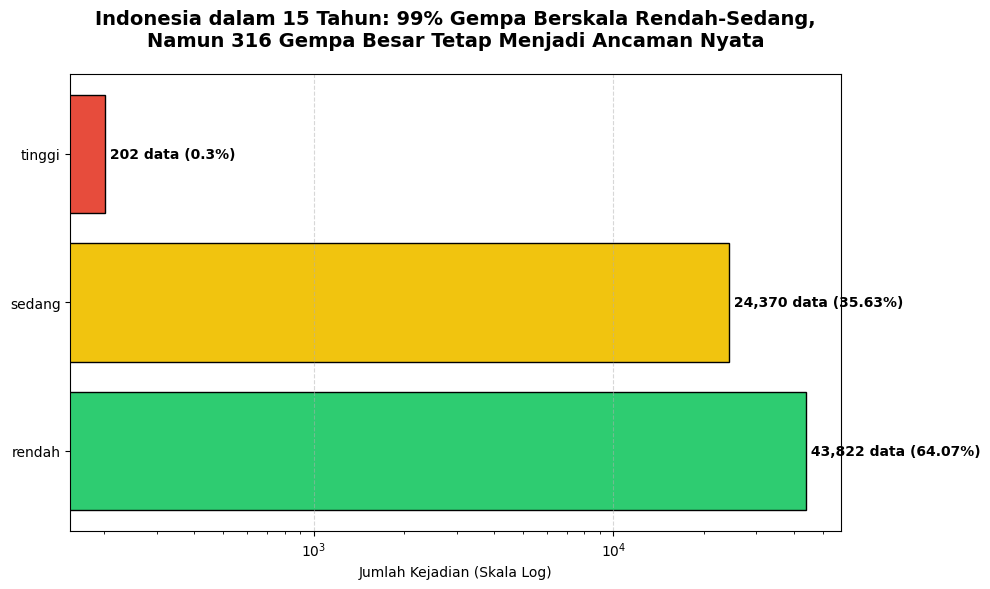

In [27]:
# Hitung jumlah dan persentase
counts = df_clean['status_gempa'].value_counts().sort_index()
total = len(df_clean)
percentages = (counts / total * 100).round(2)

# Set warna: Hijau, Kuning, Merah
colors = ['#2ecc71', '#f1c40f', '#e74c3c']

plt.figure(figsize=(10, 6))
bars = plt.barh(counts.index, counts.values, color=colors, edgecolor='black')

# Tambahin label teks di ujung 
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f' {counts.values[i]:,} data ({percentages.values[i]}%)', 
             va='center', fontweight='bold')

# Judul 
plt.title('Indonesia dalam 15 Tahun: 99% Gempa Berskala Rendah-Sedang,\nNamun 316 Gempa Besar Tetap Menjadi Ancaman Nyata', 
          fontsize=14, fontweight='bold', pad=20)

plt.xscale('log')
plt.xlabel('Jumlah Kejadian (Skala Log)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

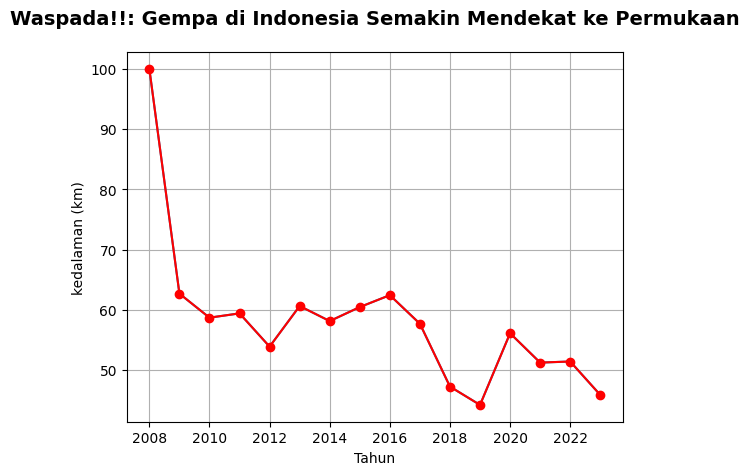

In [28]:
# Cek rata-rata kedalaman gempa tiap tahun
df_clean.groupby(df_clean['tgl'].dt.year)['depth'].mean().plot(kind='line')

# grouping dan hitung rata - rata
df_clean['tgl'] = pd.to_datetime(df_clean['tgl'])
tren_depth = df_clean.groupby(df_clean['tgl'].dt.year)['depth'].mean()

# visualisasi
tren_depth.plot(kind='line', marker = 'o', color = 'red')
plt.title("Waspada!!: Gempa di Indonesia Semakin Mendekat ke Permukaan", fontsize = 14, fontweight = 'bold', pad = 20)
plt.ylabel('kedalaman (km)')
plt.xlabel('Tahun')
plt.grid(True)
plt.show()

In [29]:
df_clean['is_sea'] = df_clean['remark'].str.contains('Sea', na=False)
df_clean.groupby('is_sea')['depth'].mean()

is_sea
False    43.184406
True     95.409485
Name: depth, dtype: float64

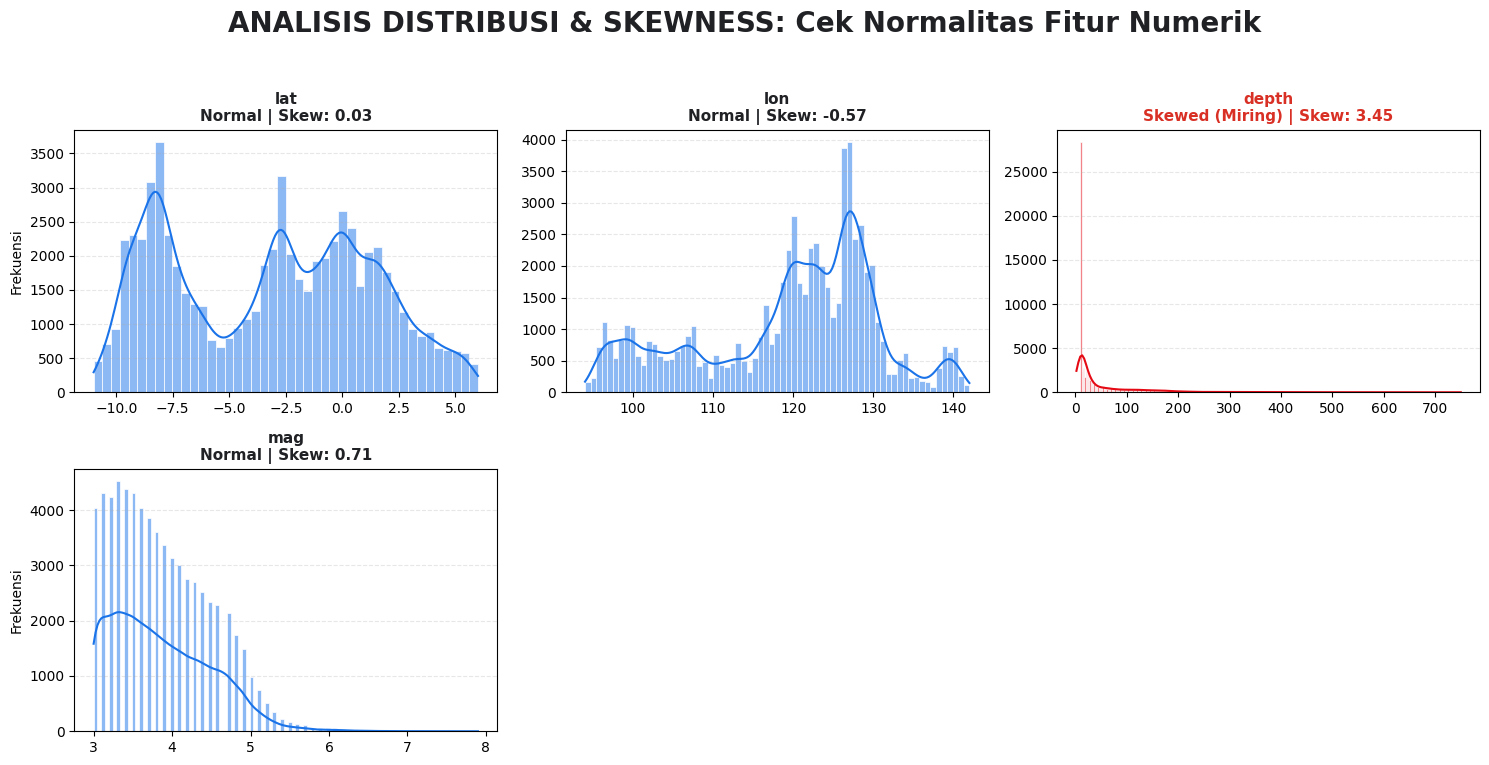

In [30]:
num = df_clean.select_dtypes(include='number')

# 1. Setup Grid
n_cols_row = 3
n_features = len(num.columns) 
n_rows = (n_features + n_cols_row - 1) // n_cols_row

# 2. Set up Canvas
plt.figure(figsize=(15, 4 * n_rows))

# Judul Utama
plt.suptitle("ANALISIS DISTRIBUSI & SKEWNESS: Cek Normalitas Fitur Numerik",
             fontsize = 20, fontweight = 'bold', y = 0.98, color = '#202124')

# 3. Looping 
for i, col in enumerate(num.columns):
    plt.subplot(n_rows, n_cols_row, i + 1)

    # Hitung statistik kemiringan data
    skew = num[col].skew()

    # Kondisi Pewarnaan 
    if abs(skew) > 1:
        bar_color = "#E50914"  
        title_color = "#D93025"
        status = 'Skewed (Miring)'
    else:
        bar_color = '#1A73E8' 
        status = 'Normal'
        title_color = "#202124"

    
    # Plot Histogram & KDE
    sns.histplot(num[col], bins='auto', kde=True,
                 color=bar_color, edgecolor='white', linewidth=0.5)
    
    # Judul Per Subplot
    plt.title(f"{col}\n{status} | Skew: {skew:.2f}", 
              fontsize=11, fontweight='bold', color=title_color)
    
    # Styling Grid & Label
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xlabel('')
    
    # Hanya tampilkan label Y di kolom paling kiri biar rapi
    plt.ylabel('Frekuensi' if i % n_cols_row == 0 else '')

# 4. Finishing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### C.2 Univariate Analsyis (Melihat Distribusi 2 Fitur / Columns)

<Figure size 1000x800 with 0 Axes>

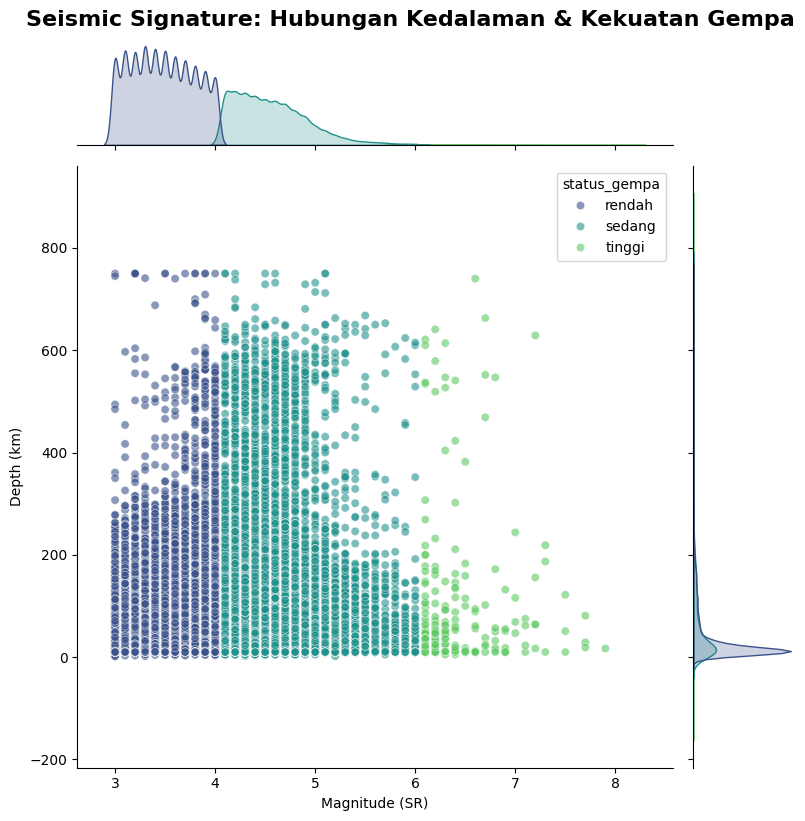

In [31]:
# 1. Hubungan Kedalaman vs Kekuatan (Magnitude vs Depth)
plt.figure(figsize=(10, 8))
g = sns.jointplot(data=df_clean, x='mag', y='depth', hue='status_gempa', 
                  palette='viridis', alpha=0.6, height=8)

# Tambahin judul (agak tricky di jointplot)
g.fig.suptitle("Seismic Signature: Hubungan Kedalaman & Kekuatan Gempa", 
               fontsize=16, fontweight='bold', y=1.02)
g.ax_joint.set_xlabel("Magnitude (SR)")
g.ax_joint.set_ylabel("Depth (km)")
plt.show()

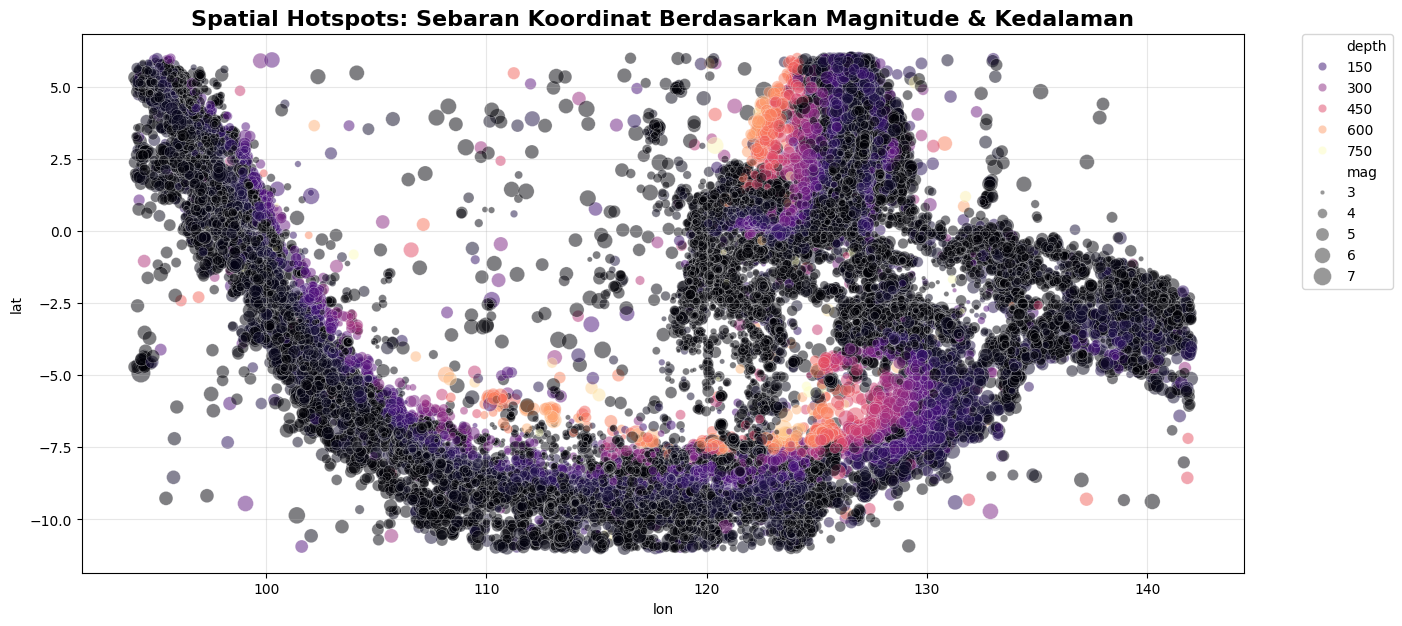

In [ ]:
# Dimana Titik-Titik Bahaya Berada?
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df_clean, x='lon', y='lat', 
                size='mag', hue='depth', palette='magma', 
                sizes=(10, 200), alpha=0.5)

plt.title("Spatial Hotspots: Sebaran Koordinat Berdasarkan Magnitude & Kedalaman", 
          fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.show()

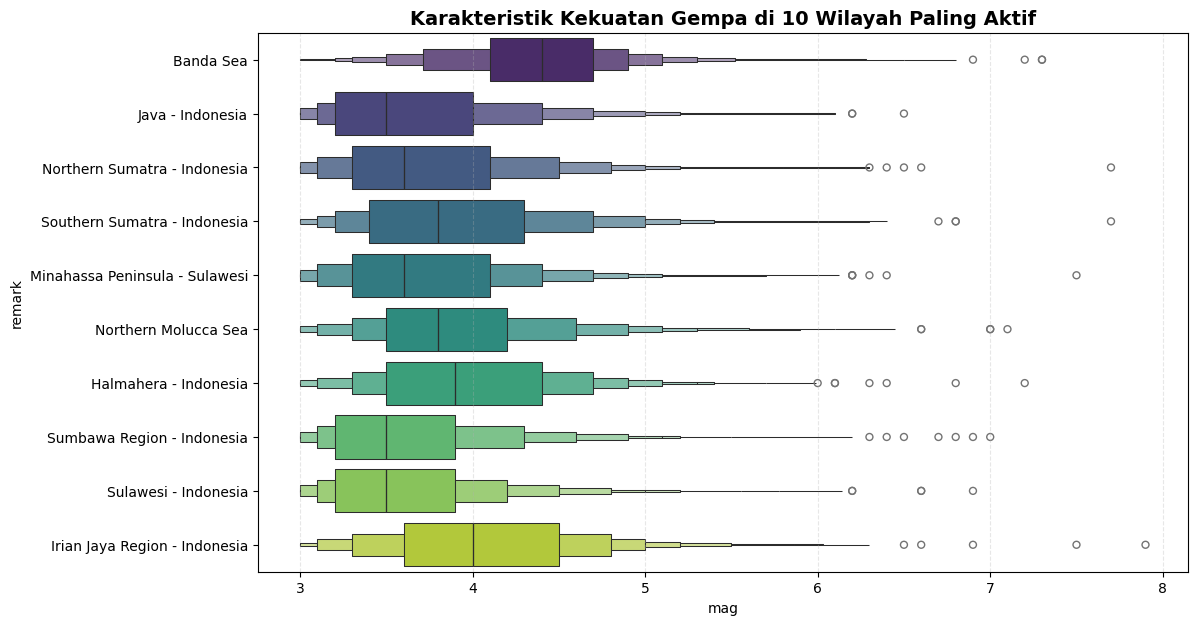

In [33]:
top_regions = df_clean['remark'].value_counts().nlargest(10).index
df_top = df_clean[df_clean['remark'].isin(top_regions)]

plt.figure(figsize=(12, 7))

sns.boxenplot(
    data=df_top, 
    y='remark', 
    x='mag', 
    hue='remark',      
    palette='viridis', 
    legend=False      
)

plt.title("Karakteristik Kekuatan Gempa di 10 Wilayah Paling Aktif", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

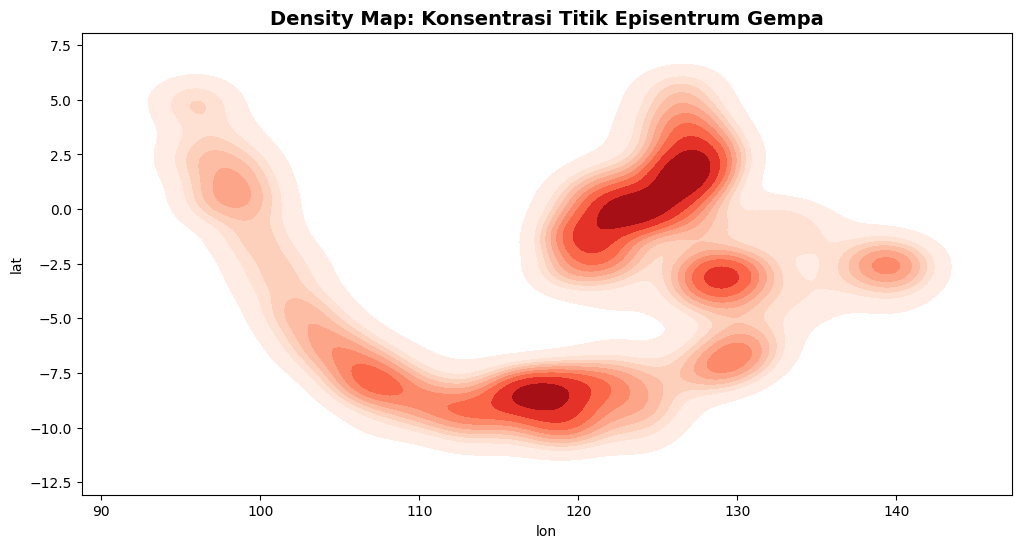

In [34]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_clean, x='lon', y='lat', cmap='Reds', fill=True, thresh=0.05, levels=10)
plt.title("Density Map: Konsentrasi Titik Episentrum Gempa", fontsize=14, fontweight='bold')
plt.show()

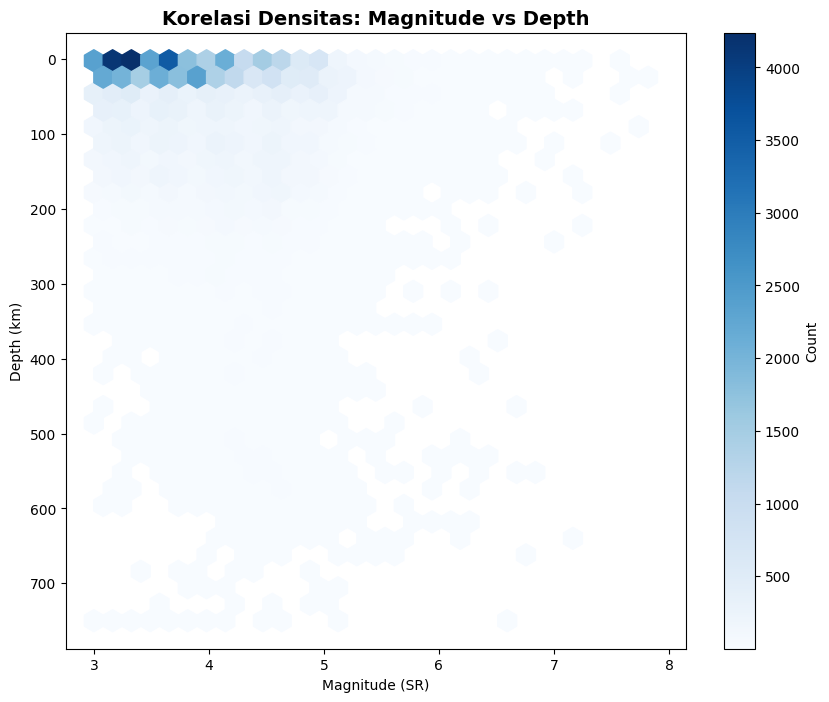

In [35]:
plt.figure(figsize=(10, 8))
plt.hexbin(df_clean['mag'], df_clean['depth'], gridsize=30, cmap='Blues', mincnt=1)
plt.colorbar(label='Count')
plt.gca().invert_yaxis() # Kedalaman makin kebawah makin gede
plt.xlabel("Magnitude (SR)")
plt.ylabel("Depth (km)")
plt.title("Korelasi Densitas: Magnitude vs Depth", fontsize=14, fontweight='bold')
plt.show()

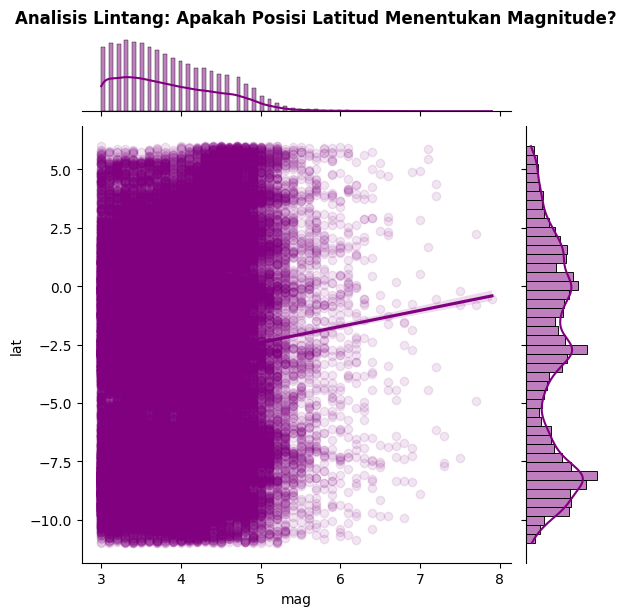

In [36]:
sns.jointplot(data=df_clean, x='mag', y='lat', kind='reg', color='purple', scatter_kws={'alpha':0.1})
plt.suptitle("Analisis Lintang: Apakah Posisi Latitud Menentukan Magnitude?", y=1.02, fontweight='bold')
plt.show()

In [37]:
# plt.figure(figsize=(10, 6))

# # stripplot + jitter 
# sns.stripplot(
#     data=df_clean.sample(1000), 
#     x='depth_cat', 
#     y='mag', 
#     hue='depth_cat', 
#     palette='coolwarm', 
#     size=4, 
#     jitter=True,   #  titiknya nyebar dikit biar gak numpuk
#     alpha=0.6,     # Efek transparan biar titik yang tumpuk kelihatan lebih pekat
#     legend=False
# )

# plt.title("Magnitude Berdasarkan Kategori Kedalaman", fontsize=14, fontweight='bold')
# plt.grid(axis='y', linestyle='--', alpha=0.3)
# plt.show()

### C.3 Multivariate Analsyis (Melihat Distribusi lebih dari 2 Fitur / Columns)

<Figure size 1200x1000 with 0 Axes>

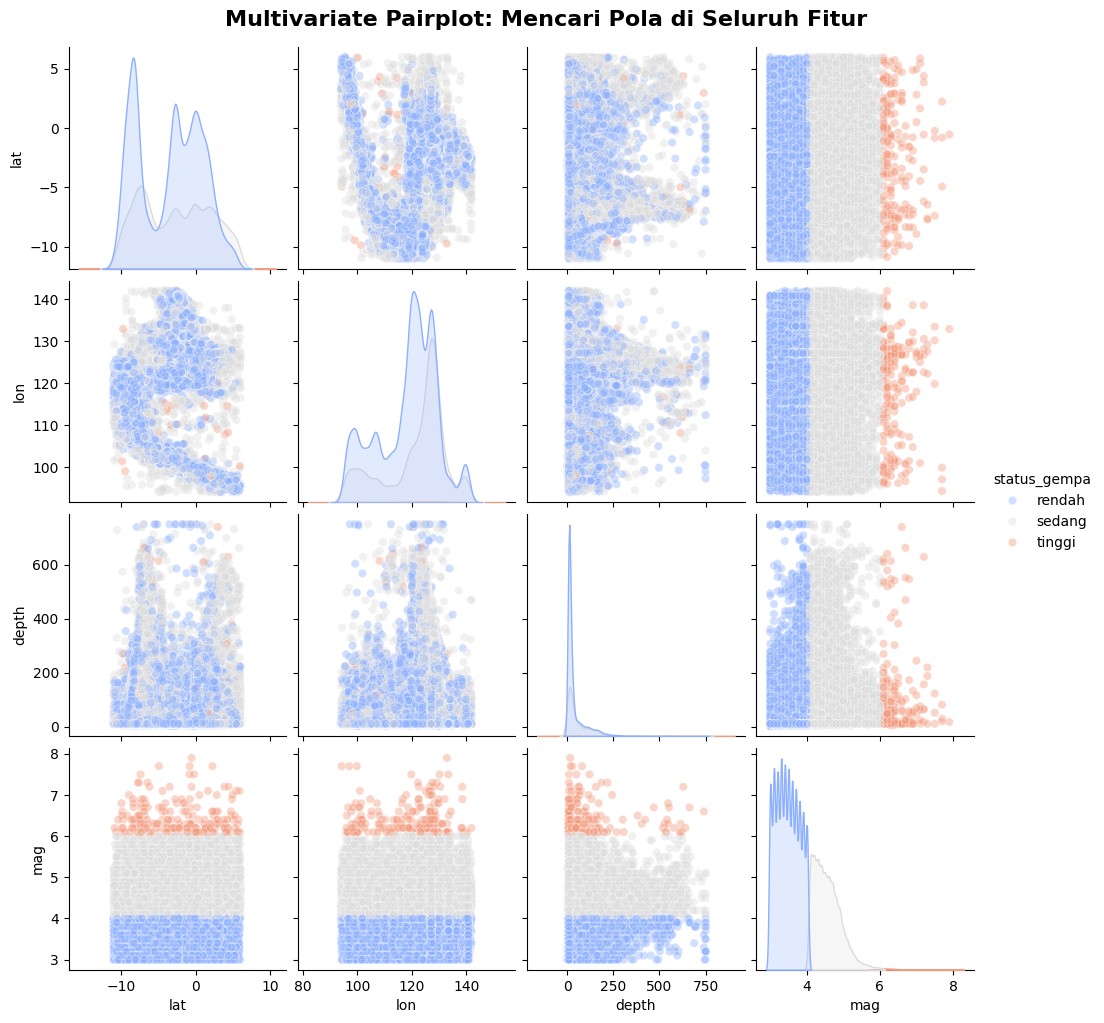

In [38]:
# Ambil fitur utama buat K-Means
features = ['lat', 'lon', 'depth', 'mag']

# Pairplot dengan warna berdasarkan status_gempa
plt.figure(figsize=(12, 10))
sns.pairplot(df_clean[features + ['status_gempa']], 
             hue='status_gempa', 
             palette='coolwarm', 
             diag_kind='kde',
             plot_kws={'alpha': 0.4})
plt.suptitle("Multivariate Pairplot: Mencari Pola di Seluruh Fitur", y=1.02, fontsize=16, fontweight='bold')
plt.show()

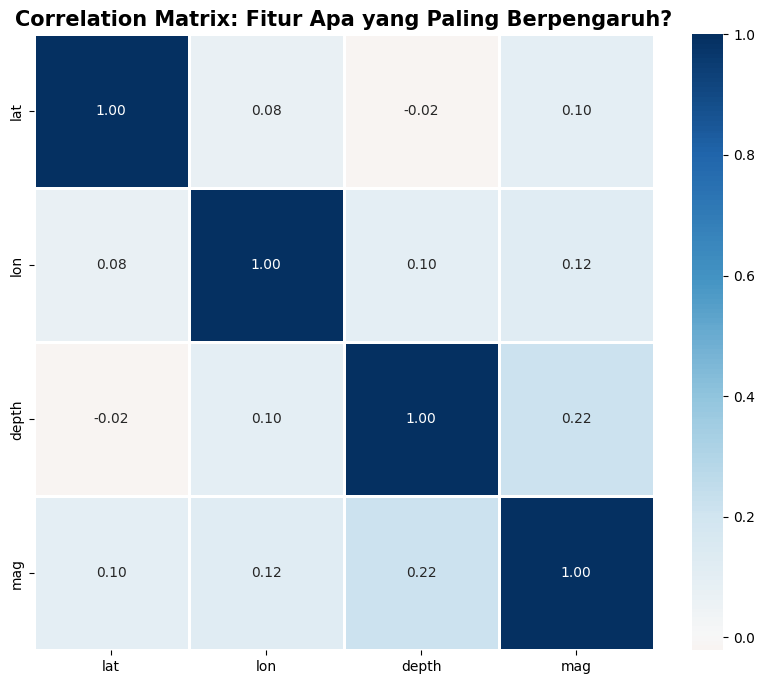

In [39]:
plt.figure(figsize=(10, 8))
corr_matrix = df_clean[features].corr()

# Gambar Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", center=0, linewidths=2)
plt.title("Correlation Matrix: Fitur Apa yang Paling Berpengaruh?", fontsize=15, fontweight='bold')
plt.show()

## D. Data Prprocessing

### Memilih Fitur Utama

In [40]:
df_clean
### Memilih Fitur Utama

,tgl,ot,lat,lon,depth,mag,remark,status_gempa,is_sea
0,2008-11-01,21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia,sedang,False
1,2008-11-01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea,sedang,True
2,2008-11-01,17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia,rendah,False
3,2008-11-01,16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia,rendah,False
4,2008-11-01,16:20:37.327,-6.41,129.54,70,4.3,Banda Sea,sedang,True
...,...,...,...,...,...,...,...,...,...
92880,2023-01-26,02:45:01.461,-2.38,140.77,10,3.1,Near North Coast of Irian Jaya,rendah,False
92882,2023-01-26,02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia,rendah,False
92883,2023-01-26,02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea,rendah,True
92884,2023-01-26,01:57:08.885,-7.83,121.07,10,3.8,Flores Sea,rendah,True


In [41]:
print("\n ---- Memilih Fitur Utama ----")

x_features = ['lat', 'lon', 'depth', 'mag']
x_copy = df_clean[features].copy()

print(f"\n[Data Setelah Transformasi Logaritma]")
display(x_copy.head())


 ---- Memilih Fitur Utama ----

[Data Setelah Transformasi Logaritma]


,lat,lon,depth,mag
0,-9.18,119.06,10,4.9
1,-6.55,129.64,10,4.6
2,-7.01,106.63,121,3.7
3,-3.30,127.85,10,3.2
4,-6.41,129.54,70,4.3


### Transformasi Logaritma

In [42]:
print("\n ---- Transformasi Lgaritma ----")

x_copy['depth'] = np.log1p(x_copy['depth'])
x_copy['mag'] = np.log1p(x_copy['mag'])

print(f"\n[Data Setelah Transformasi Logaritma]")
display(x_copy.head())


 ---- Transformasi Lgaritma ----

[Data Setelah Transformasi Logaritma]


,lat,lon,depth,mag
0,-9.18,119.06,2.397895,1.774952
1,-6.55,129.64,2.397895,1.722767
2,-7.01,106.63,4.804021,1.547563
3,-3.30,127.85,2.397895,1.435085
4,-6.41,129.54,4.262680,1.667707


### Min - Max Scaling

In [43]:
print("\n ---- SCALING DENGAN MIN - MAX SCALING ----")

x_min = x_copy.min()
x_max = x_copy.max()

x_scaled = (x_copy - x_min) / (x_max - x_min)

print(f"\n[DATA AFTER SCALING]")
display(x_scaled.describe().T.style.format("{:.2f}"))

print("\n[PREVIEW 5 DATA FINAL]")
display(x_scaled.head())

print(f"\nTotal Data Siap Modeling: {x_scaled.shape[0]} Baris, {x_scaled.shape[1]} Fitur")


 ---- SCALING DENGAN MIN - MAX SCALING ----

[DATA AFTER SCALING]


,count,mean,std,min,25%,50%,75%,max
lat,68394.00,0.46,0.26,0.00,0.20,0.48,0.67,1.00
lon,68394.00,0.53,0.23,0.00,0.39,0.59,0.69,1.00
depth,68394.00,0.41,0.19,0.00,0.24,0.33,0.55,1.00
mag,68394.00,0.24,0.16,0.00,0.09,0.23,0.35,1.00



[PREVIEW 5 DATA FINAL]


,lat,lon,depth,mag
0,0.107059,0.521884,0.235258,0.485970
1,0.261765,0.742393,0.235258,0.420718
2,0.234706,0.262818,0.670930,0.201646
3,0.452941,0.705085,0.235258,0.061006
4,0.270000,0.740308,0.572911,0.351872



Total Data Siap Modeling: 68394 Baris, 4 Fitur


In [44]:
print(" --- Transformasi DataFrame ke Array (Agar Lebih Cepat) --- ")
x_final = x_scaled.values

print(f'Dimensi Data: {x_final.shape}')
print(f"Rentang Nilai (MIN) {x_final.min()}")
print(f"Rentang Nilai (MAX) {x_final.max()}")

 --- Transformasi DataFrame ke Array (Agar Lebih Cepat) --- 
Dimensi Data: (68394, 4)
Rentang Nilai (MIN) 0.0
Rentang Nilai (MAX) 1.0


## E. Modeling

### K - Means

In [45]:
class KMeans:
    def __init__(self, k=3, max_iter=300, tol=1e-4, random_state=42):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.inertia_ = 0

    def _calculate_distance(self, X, centroids):
        # Step 3A: Hitung Jarak Euclidean (Vectorized NumPy)
        # Menghitung jarak tiap titik ke semua centroid sekaligus
        distances = np.sqrt(((X[:, np.newaxis] - centroids)**2).sum(axis=2))
        return distances

    def fit(self, X):
        # Step 2: Inisialisasi Centroid Secara Acak
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        self.centroids = X[random_idx[:self.k]]

        for i in range(self.max_iter):
            old_centroids = self.centroids.copy()

            # Step 3A: Assignment - Cari centroid terdekat buat tiap titik
            distances = self._calculate_distance(X, self.centroids)
            self.labels_ = np.argmin(distances, axis=1)

            # Step 3B: Update - Hitung rata-rata posisi baru tiap klaster
            new_centroids = np.array([X[self.labels_ == j].mean(axis=0) 
                                      if len(X[self.labels_ == j]) > 0 
                                      else self.centroids[j] 
                                      for j in range(self.k)])
            
            self.centroids = new_centroids

            # Step 4: Convergence Check - Berhenti kalau gesernya udah dikit banget
            if np.all(np.abs(new_centroids - old_centroids) < self.tol):
                break
        
        # Hitung Inertia (Total Jarak Kuadrat) buat Elbow Method
        final_distances = self._calculate_distance(X, self.centroids)
        closest_dist = np.min(final_distances, axis=1)
        self.inertia_ = np.sum(closest_dist**2)

    def predict(self, X):
        distances = self._calculate_distance(X, self.centroids)
        return np.argmin(distances, axis=1)

### Visualisasi Pergerakan Centroid

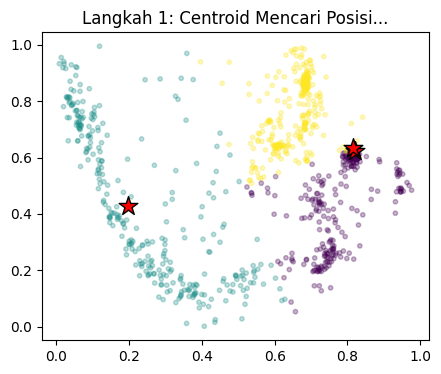

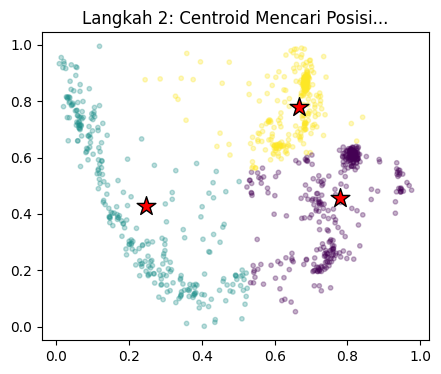

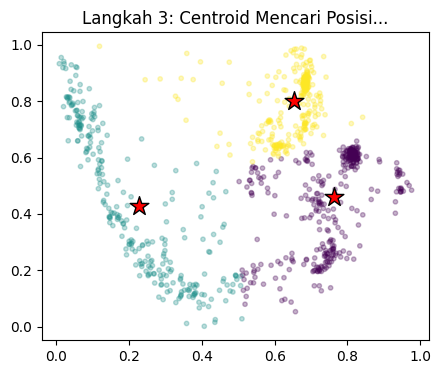

In [46]:
# Ambil sample 1000 data
X_sample = x_final[:1000, :2]
centroids = X_sample[np.random.choice(1000, 3)] # Inisialisasi acak

for i in range(3):
    # Cari cluster terdekat 
    dist = np.linalg.norm(X_sample[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(dist, axis=1)
    
    # Visualisasi
    plt.figure(figsize=(5, 4))
    plt.scatter(X_sample[:, 1], X_sample[:, 0], c=labels, s=10, alpha=0.3, cmap='viridis')
    plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='*', s=200, edgecolors='black')
    plt.title(f"Langkah {i+1}: Centroid Mencari Posisi..."); plt.show()
    
    # Update
    centroids = np.array([X_sample[labels == k].mean(axis=0) for k in range(3)])

### Elbow Method

Sedang menghitung Elbow Method... 
K=1 selesai. Inertia: 12540.83
K=2 selesai. Inertia: 8757.95
K=3 selesai. Inertia: 6474.71
K=4 selesai. Inertia: 5152.98
K=5 selesai. Inertia: 4756.86
K=6 selesai. Inertia: 3881.44
K=7 selesai. Inertia: 3708.68
K=8 selesai. Inertia: 3447.16
K=9 selesai. Inertia: 3273.44
K=10 selesai. Inertia: 2900.17


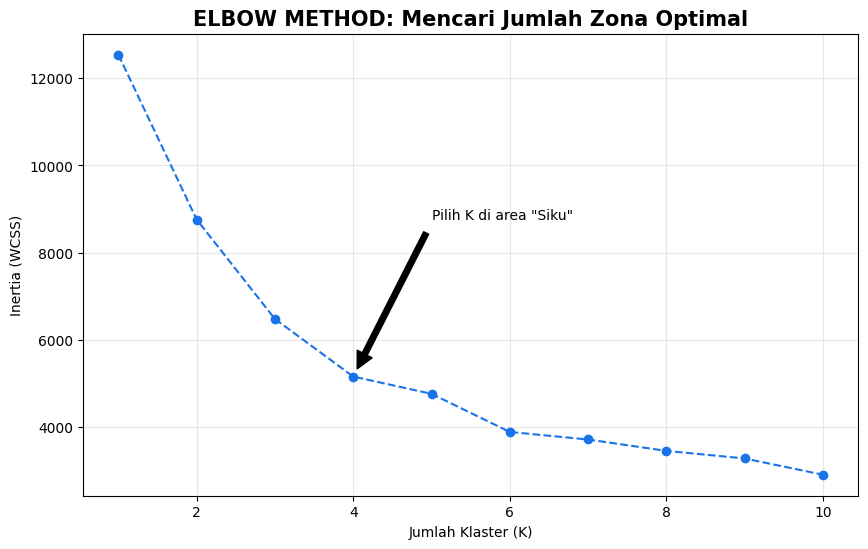

In [47]:
# List buat nampung nilai inertia 
inertia_list = []
K_range = range(1, 11)

print("Sedang menghitung Elbow Method... ")

for k in K_range:
    model = KMeans(k=k, max_iter=100, random_state=42)
    model.fit(x_final) # x_final adalah array hasil preprocessing tadi
    inertia_list.append(model.inertia_)
    print(f"K={k} selesai. Inertia: {model.inertia_:.2f}")

# Visualisasi Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_list, marker='o', linestyle='--', color='#1A73E8')
plt.title('ELBOW METHOD: Mencari Jumlah Zona Optimal', fontsize=15, fontweight='bold')
plt.xlabel('Jumlah Klaster (K)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True, alpha=0.3)
plt.annotate('Pilih K di area "Siku"', xy=(4, inertia_list[3]), xytext=(5, inertia_list[1]),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

### Final Cluster

In [48]:
# 1. Pilih K terbaik hasil Elbow
k_optimal = 4 

# 2. Inisialisasi dan Fit Model Final
model_final = KMeans(k=k_optimal, max_iter=300, random_state=42)
model_final.fit(x_final)

# 3. Ambil Label Cluster
labels = model_final.labels_

# 4. Masukkan Label ke DataFrame Original biar bisa dianalisis
df_clean['cluster'] = labels

print(f"Model Final dengan K={k_optimal} berhasil dijalankan!")
print(df_clean['cluster'].value_counts())

Model Final dengan K=4 berhasil dijalankan!
cluster
1    24810
2    21053
3    13650
0     8881
Name: count, dtype: int64


### Visualisasi Cluster Peta Indonesia


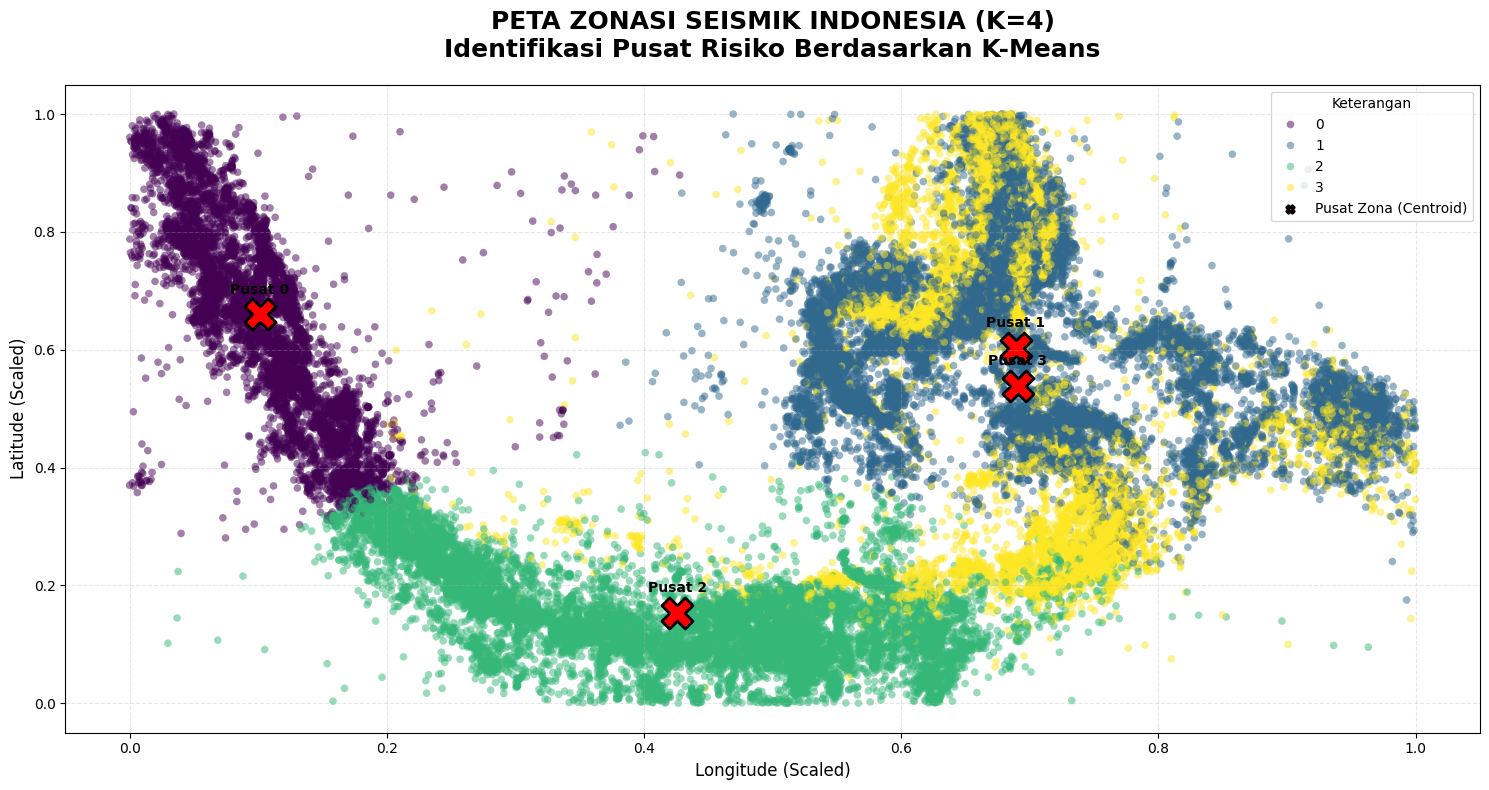

In [49]:
plt.figure(figsize=(15, 8))

# 1. Plot Data Points
sns.scatterplot(
    x=x_final[:, 1], 
    y=x_final[:, 0], 
    hue=labels, 
    palette='viridis', 
    s=30, 
    alpha=0.5, 
    edgecolor='none'
)

# 2. Plot Centroids
plt.scatter(
    model_final.centroids[:, 1], 
    model_final.centroids[:, 0], 
    c='red', 
    marker='X', 
    s=500,               
    edgecolor='black', 
    linewidth=2,
    label='Pusat Zona (Centroid)'
)

# 3.  Styling
plt.title(f"PETA ZONASI SEISMIK INDONESIA (K={k_optimal})\nIdentifikasi Pusat Risiko Berdasarkan K-Means", 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Longitude (Scaled)", fontsize=12)
plt.ylabel("Latitude (Scaled)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)


# legendanya 
lgnd = plt.legend(loc='upper right', title="Keterangan", frameon=True)
lgnd.legend_handles[-1]._sizes = [30]

# anotasi untuk Centroid
for i, (lat, lon, d, m) in enumerate(model_final.centroids):
    plt.annotate(f"Pusat {i}", (lon, lat), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center', 
                 fontweight='bold', 
                 color='black')

plt.tight_layout()
plt.show()

### Statistik Cluster

In [50]:
df_final = df_clean.copy()
df_final['cluster'] = labels

# Hitung statistik per cluster
profiling = df_final.groupby('cluster').agg({
    'mag': ['mean', 'max'],
    'depth': ['mean', 'max'],
    'lat': 'count' # lihat jumlah kejadian
}).reset_index()

profiling.columns = ['Cluster', 'Avg_Mag', 'Max_Mag', 'Avg_Depth', 'Max_Depth', 'Total_Events']
display(profiling.style.background_gradient(cmap='Reds'))

,Cluster,Avg_Mag,Max_Mag,Avg_Depth,Max_Depth,Total_Events
0,0,3.884540,7.700000,40.393762,750,8881
1,1,3.769303,7.500000,15.205683,77,24810
2,2,3.704351,7.300000,36.798034,494,21053
3,3,4.292579,7.900000,160.400366,750,13650


## F. Evaluasi

### Silhoutte Score

In [51]:
def calculate_silhouette_manual(X, labels):
    n_samples = X.shape[0]
    unique_labels = np.unique(labels)
    
    # Tempat nampung nilai s(i)
    silhouette_vals = []

    for i in range(n_samples):
        # 1. Pisahkan titik i dan klaster lainnya
        current_point = X[i]
        current_label = labels[i]
        
        # 2. Hitung a(i) - Jarak ke teman se-cluster
        same_cluster_points = X[labels == current_label]
        if len(same_cluster_points) > 1:
            # Hitung jarak ke semua titik di cluster yang sama
            # (Hapus jarak ke diri sendiri agar tidak jadi 0)
            a_i = np.mean(np.linalg.norm(same_cluster_points - current_point, axis=1))
        else:
            a_i = 0
            
        # 3. Hitung b(i) - Jarak ke cluster tetangga terdekat
        b_i_list = []
        for other_label in unique_labels:
            if other_label == current_label:
                continue
            
            other_cluster_points = X[labels == other_label]
            avg_dist_to_other = np.mean(np.linalg.norm(other_cluster_points - current_point, axis=1))
            b_i_list.append(avg_dist_to_other)
            
        b_i = min(b_i_list) if b_i_list else 0
        
        # 4. Hitung s(i)
        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
        silhouette_vals.append(s_i)
        
    return np.mean(silhouette_vals)

In [52]:
np.random.seed(42)
sample_idx = np.random.choice(len(x_final), 1000, replace=False)
x_sample = x_final[sample_idx]
labels_sample = labels[sample_idx]

manual_score = calculate_silhouette_manual(x_sample, labels_sample)

print(f"--- EVALUASI MODEL ---")
print(f"Silhouette Score (N=1000): {manual_score:.4f}")

if manual_score > 0.5:
    print("Interpretasi: Cluster Terpisah Sangat Baik (Strong Structure)")
elif manual_score > 0.25:
    print("Interpretasi: Cluster Terpisah Cukup Baik (Reasonable Structure)")
else:
    print("Interpretasi: Cluster Agak Tumpang Tindih (Weak Structure)")

--- EVALUASI MODEL ---
Silhouette Score (N=1000): 0.3552
Interpretasi: Cluster Terpisah Cukup Baik (Reasonable Structure)


## GUI

In [ ]:
import tkinter as tk
from tkinter import messagebox, font
import numpy as np

class SeismicPredictorGUI:
    def __init__(self, root, model, x_min, x_max):
        self.root = root
        self.model = model
        self.x_min = x_min
        self.x_max = x_max
        
        # DATABASE SAMPLE 
        self.samples = [
            {"Name": "Gempa Aceh 2004", "Lat": 3.31, "Lon": 95.85, "Depth": 30.0, "Mag": 9.1},
            {"Name": "Gempa Palu 2018", "Lat": -0.22, "Lon": 119.85, "Depth": 10.0, "Mag": 7.5},
            {"Name": "Gempa Flores 2021", "Lat": -7.50, "Lon": 122.21, "Depth": 500.0, "Mag": 6.2},
            {"Name": "Gempa Cianjur 2022", "Lat": -6.84, "Lon": 107.05, "Depth": 11.0, "Mag": 5.6},
            {"Name": "Gempa Laut Banda", "Lat": -6.50, "Lon": 129.50, "Depth": 620.0, "Mag": 7.1}
        ]
        
        # KONFIGURASI TEMA
        self.color_bg = "#0F172A"      
        self.color_card = "#1E293B"    
        self.color_accent = "#10B981"  
        self.color_text = "#F8FAFC"    
        self.color_dim = "#94A3B8"     
        
        self.root.title("SEISMIC ZONING INTELLIGENCE v2.6")
        self.root.geometry("1000x650")
        self.root.configure(bg=self.color_bg)
        
        self.font_mono = font.Font(family="Consolas", size=10)
        self.font_label = font.Font(family="Segoe UI", size=10, weight="bold")

        self.setup_ui()

    def setup_ui(self):
        # 1. SIDEBAR
        self.sidebar = tk.Frame(self.root, bg=self.color_card, width=350)
        self.sidebar.pack(side=tk.LEFT, fill=tk.Y, padx=20, pady=20)
        self.sidebar.pack_propagate(False)

        tk.Label(self.sidebar, text="CONTROL PANEL", fg=self.color_accent, 
                 bg=self.color_card, font=self.font_label).pack(pady=(20, 10))

        # TOMBOL FETCH SAMPLE 
        self.btn_fetch = tk.Button(self.sidebar, text="FETCH RANDOM SAMPLE", command=self.fetch_sample,
                                   bg=self.color_card, fg=self.color_accent, font=("Segoe UI", 9, "bold"),
                                   relief="flat", cursor="hand2", borderwidth=1, 
                                   highlightbackground=self.color_accent, highlightthickness=1)
        self.btn_fetch.pack(fill=tk.X, padx=30, pady=(0, 20), ipady=5)
        
        self.btn_fetch.bind("<Enter>", lambda e: self.btn_fetch.config(bg="#1e2d4d"))
        self.btn_fetch.bind("<Leave>", lambda e: self.btn_fetch.config(bg=self.color_card))

        # Input Fields
        self.entries = {}
        fields = [('Latitude', 'LAT'), ('Longitude', 'LON'), ('Depth', 'KM'), ('Magnitude', 'MW')]
        
        for label, unit in fields:
            frame = tk.Frame(self.sidebar, bg=self.color_card)
            frame.pack(fill=tk.X, padx=30, pady=8)
            tk.Label(frame, text=f"{label} ({unit})", fg=self.color_dim, 
                     bg=self.color_card, font=("Segoe UI", 9)).pack(anchor="w")
            
            e = tk.Entry(frame, bg=self.color_bg, fg=self.color_accent, 
                         insertbackground="white", font=("Consolas", 12),
                         relief="flat", borderwidth=0)
            e.pack(fill=tk.X, ipady=8, pady=5)
            tk.Frame(frame, height=2, bg="#334155").pack(fill=tk.X)
            self.entries[label] = e

        # Tombol Prediksi
        self.btn_predict = tk.Button(self.sidebar, text="EXECUTE ANALYSIS", command=self.run_prediction,
                                     bg=self.color_accent, fg=self.color_bg, font=("Segoe UI", 10, "bold"),
                                     relief="flat", cursor="hand2", activebackground="#34D399")
        self.btn_predict.pack(fill=tk.X, padx=30, pady=30, ipady=12)
        
        self.btn_predict.bind("<Enter>", lambda e: self.btn_predict.config(bg="#34D399"))
        self.btn_predict.bind("<Leave>", lambda e: self.btn_predict.config(bg=self.color_accent))

        # MAIN VIEW
        self.main = tk.Frame(self.root, bg=self.color_bg)
        self.main.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=(0, 20), pady=20)

        tk.Label(self.main, text="INTELLIGENCE REPORT", fg=self.color_dim, 
                 bg=self.color_bg, font=self.font_label).pack(anchor="w")
        
        self.zone_display = tk.Label(self.main, text="ZONA: --", fg=self.color_text, 
                                     bg=self.color_bg, font=("Segoe UI", 48, "bold"))
        self.zone_display.pack(anchor="w", pady=10)

        self.terminal = tk.Text(self.main, bg="#020617", fg="#10B981", font=self.font_mono,
                                relief="flat", padx=20, pady=20, borderwidth=0)
        self.terminal.pack(fill=tk.BOTH, expand=True)
        self.terminal.insert("1.0", "> System Ready. Awaiting seismic parameters...")
        self.terminal.config(state="disabled")

    #  FUNGSI FETCH 
    def fetch_sample(self):
        # Pakai np.random agar konsisten dengan ekosistem data 
        idx = np.random.randint(0, len(self.samples))
        sample = self.samples[idx]
        
        # Mapping data ke entry
        self.entries['Latitude'].delete(0, tk.END)
        self.entries['Latitude'].insert(0, str(sample['Lat']))
        
        self.entries['Longitude'].delete(0, tk.END)
        self.entries['Longitude'].insert(0, str(sample['Lon']))
        
        self.entries['Depth'].delete(0, tk.END)
        self.entries['Depth'].insert(0, str(sample['Depth']))
        
        self.entries['Magnitude'].delete(0, tk.END)
        self.entries['Magnitude'].insert(0, str(sample['Mag']))
        
        # Notifikasi di Terminal
        self.terminal.config(state="normal")
        self.terminal.delete("1.0", tk.END)
        self.terminal.insert(tk.END, f"[!] DATA FETCHED: {sample['Name']}\n")
        self.terminal.insert(tk.END, f"> Parameters loaded. System ready for execution.")
        self.terminal.config(state="disabled")

    def run_prediction(self):
        try:
            inputs = [float(self.entries[f].get()) for f in ['Latitude', 'Longitude', 'Depth', 'Magnitude']]
            
            # Preprocessing
            inputs[2] = np.log1p(inputs[2])
            inputs[3] = np.log1p(inputs[3])
            
            scaled = (np.array(inputs) - self.x_min.values) / (self.x_max.values - self.x_min.values)
            
            distances = np.sqrt(((self.model.centroids - scaled)**2).sum(axis=1))
            cluster = np.argmin(distances)

            self.zone_display.config(text=f"ZONA: {cluster}")
            self.log_terminal(inputs, distances, cluster)

        except Exception as e:
            messagebox.showerror("System Error", "Input tidak valid.")

    def log_terminal(self, raw, dists, res):
        self.terminal.config(state="normal")
        self.terminal.delete("1.0", tk.END)
        self.terminal.insert(tk.END, f"[#] ANALYSIS SEQUENCE INITIATED\n")
        self.terminal.insert(tk.END, f"[#] STATUS: COMPUTING EUCLIDEAN DISTANCE...\n")
        self.terminal.insert(tk.END, "-"*45 + "\n")
        
        for i, d in enumerate(dists):
            status = "<<< MATCH" if i == res else ""
            self.terminal.insert(tk.END, f" ZONE {i} DIST : {d:.8f} {status}\n")
            
        self.terminal.insert(tk.END, "-"*45 + "\n")
        self.terminal.insert(tk.END, f"[#] RESULT: CLASSIFIED INTO ZONA {res}")
        self.terminal.config(state="disabled")

if __name__ == "__main__":
    root = tk.Tk()
    app = SeismicPredictorGUI(root, model_final, x_min, x_max)
    root.mainloop()